In [3]:
from torch.utils.data import DataLoader
from torchvision import transforms
from progressBar import printProgressBar

import medicalDataLoader
import argparse
from utils import *

from UNet_Base import *
import random
import torch
import pdb

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
def runTraining():
    print('-' * 40)
    print('~~~~~~~~  Starting the training... ~~~~~~')
    print('-' * 40)

    ## DEFINE HYPERPARAMETERS (batch_size > 1)
    batch_size = 4
    batch_size_val = 4
    lr = 0.002    # Learning Rate
    epoch = 50 # Number of epochs
    
    root_dir = './data/'

    print(' Dataset: {} '.format(root_dir))

    ## DEFINE THE TRANSFORMATIONS TO DO AND THE VARIABLES FOR TRAINING AND VALIDATION
    
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    mask_transform = transforms.Compose([
        transforms.ToTensor()
    ])

    train_set_full = medicalDataLoader.MedicalImageDataset('train',
                                                      root_dir,
                                                      transform=transform,
                                                      mask_transform=mask_transform,
                                                      augment=False,
                                                      equalize=False)

    train_loader_full = DataLoader(train_set_full,
                              batch_size=batch_size,
                              worker_init_fn=np.random.seed(0),
                              num_workers=0,
                              shuffle=True)


    val_set = medicalDataLoader.MedicalImageDataset('val',
                                                    root_dir,
                                                    transform=transform,
                                                    mask_transform=mask_transform,
                                                    equalize=False)

    val_loader = DataLoader(val_set,
                            batch_size=batch_size_val,
                            worker_init_fn=np.random.seed(0),
                            num_workers=0,
                            shuffle=False)


    ## INITIALIZE YOUR MODEL
    num_classes = 4 # NUMBER OF CLASSES

    print("~~~~~~~~~~~ Creating the UNet model ~~~~~~~~~~")
    modelName = 'Test_Model'
    print(" Model Name: {}".format(modelName))

    ## CREATION OF YOUR MODEL
    net = UNet(num_classes)

    print("Total params: {0:,}".format(sum(p.numel() for p in net.parameters() if p.requires_grad)))

    # DEFINE YOUR OUTPUT COMPONENTS (e.g., SOFTMAX, LOSS FUNCTION, ETC)
    softMax = torch.nn.Softmax(dim=1)
    CE_loss = torch.nn.CrossEntropyLoss()

    ## PUT EVERYTHING IN GPU RESOURCES    
    if torch.cuda.is_available():
        net.cuda()
        softMax.cuda()
        CE_loss.cuda()

    ## DEFINE YOUR OPTIMIZER
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    ### To save statistics ####
    lossTotalTraining = []
    Best_loss_val = 1000
    BestEpoch = 0
    
    directory = 'Results/Statistics/' + modelName

    print("~~~~~~~~~~~ Starting the training ~~~~~~~~~~")
    if os.path.exists(directory)==False:
        os.makedirs(directory)

    ## START THE TRAINING
    
    ## FOR EACH EPOCH
    for i in range(epoch):
        net.train()
        lossEpoch = []
        DSCEpoch = []
        DSCEpoch_w = []
        num_batches = len(train_loader_full)
        
        ## FOR EACH BATCH
        for j, data in enumerate(train_loader_full):
            ### Set to zero all the gradients
            net.zero_grad()
            optimizer.zero_grad()

            ## GET IMAGES, LABELS and IMG NAMES
            images, labels, img_names = data 

            ### From numpy to torch variables
            labels = to_var(labels)
            images = to_var(images)

            ################### Train ###################
            #-- The CNN makes its predictions (forward pass)
            net_predictions = net(images)

            #-- Compute the losses --#
            # THIS FUNCTION IS TO CONVERT LABELS TO A FORMAT TO BE USED IN THIS CODE
            segmentation_classes = getTargetSegmentation(labels)
            
            # COMPUTE THE LOSS
            CE_loss_value = CE_loss(net_predictions, segmentation_classes) # XXXXXX and YYYYYYY are your inputs for the CE
            lossTotal = CE_loss_value

            # DO THE STEPS FOR BACKPROP (two things to be done in pytorch)
            lossTotal.backward()
            optimizer.step()

            # THIS IS JUST TO VISUALIZE THE TRAINING 
            lossEpoch.append(lossTotal.cpu().data.numpy())
            printProgressBar(j + 1, num_batches,
                             prefix="[Training] Epoch: {} ".format(i),
                             length=15,
                             suffix=" Loss: {:.4f}, ".format(lossTotal))

        lossEpoch = np.asarray(lossEpoch)
        lossEpoch = lossEpoch.mean()

        lossTotalTraining.append(lossEpoch)

        printProgressBar(num_batches, num_batches,
                             done="[Training] Epoch: {}, LossG: {:.4f}".format(i,lossEpoch))

        
        ## THIS IS HOW YOU WILL SAVE THE TRAINED MODELS AFTER EACH EPOCH. 
        ## WARNING!!!!! YOU DON'T WANT TO SAVE IT AT EACH EPOCH, BUT ONLY WHEN THE MODEL WORKS BEST ON THE VALIDATION SET!!
        if not os.path.exists('./models/' + modelName):
            os.makedirs('./models/' + modelName)

        torch.save(net.state_dict(), './models/' + modelName + '/' + str(i) + '_Epoch')
            
        np.save(os.path.join(directory, 'Losses.npy'), lossTotalTraining)


In [11]:
runTraining()

----------------------------------------
~~~~~~~~  Starting the training... ~~~~~~
----------------------------------------
 Dataset: ./data/ 
~~~~~~~~~~~ Creating the UNet model ~~~~~~~~~~
 Model Name: Test_Model
Total params: 60,664
~~~~~~~~~~~ Starting the training ~~~~~~~~~~
[Training] Epoch: 0 [DONE]                                 
[Training] Epoch: 0, LossG: 1.4737                                                                           
[Training] Epoch: 1 [DONE]                                 
[Training] Epoch: 1, LossG: 1.0241                                                                           
[Training] Epoch: 2 [DONE]                                 
[Training] Epoch: 2, LossG: 0.7880                                                                           
[Training] Epoch: 3 [DONE]                                 
[Training] Epoch: 3, LossG: 0.5913                                                                           
[Training] Epoch: 4 [DONE]              

Text(0, 0.5, 'Loss')

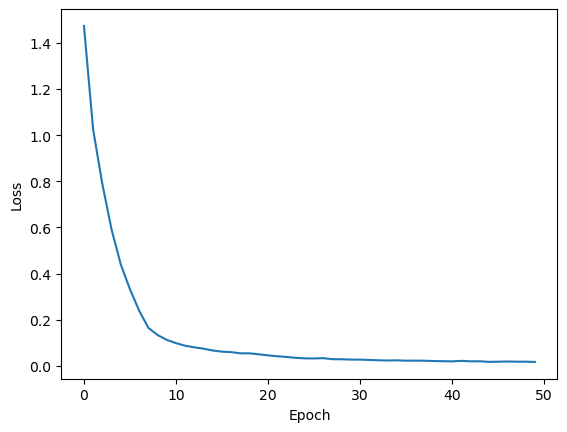

In [12]:
import matplotlib.pyplot as plt

losses = np.load('Results/Statistics/Test_Model/Losses.npy')

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
# Test sur l'ensemble de validation 

def runTesting():
    print('-' * 40)
    print('~~~~~~~~  Starting the testing... ~~~~~~')
    print('-' * 40)

    ## DEFINE HYPERPARAMETERS (batch_size > 1)
    batch_size = 4
    batch_size_val = 4
    lr = 0.002    # Learning Rate
    epoch = 50 # Number of epochs
    
    root_dir = './data/'

    print(' Dataset: {} '.format(root_dir))

